In [ ]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade
!pip install s3fs shap boto3 pandas numpy matplotlib sagemaker smdebug

In [7]:
import re
import s3fs #for s3
import shap #display model
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-10-18 18:12:42.600 default:210 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [8]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

## Preprocess the dataset
def preprocess_data(file_path):  
  df = pd.read_csv(file_path)
  ## Convert to datetime columns
  df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
  df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
  ## Drop Rows with null values
  df = df.dropna()    
  ## Create Column which gives the days between the last order and the first order
  df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
  ## Create Column which gives the days between when the customer record was created and the first order
  df['created'] = pd.to_datetime(df['created'])
  df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
  ## Drop Columns
  df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
  ## Apply one hot encoding on favday and city columns
  df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
  return df

## Set the required configurations
model_name = "churn_model"
env = "dev"
## S3 Bucket
default_bucket = "sagemaker-studio-904233106637-2fozrjwkocr"


In [9]:
## Preprocess the dataset
storedata = preprocess_data(f"s3://{default_bucket}/storedata_total.csv")

/tmp/ipykernel_210/2800608729.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
/tmp/ipykernel_210/2800608729.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
/tmp/ipykernel_210/2800608729.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created'] = pd.to_datetime(df['created'])


In [10]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29.0,100.000000,3.448276,14.52,0.000000,0.0,0.0,0.0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95.0,92.631579,10.526316,83.69,0.181641,1.0,1.0,1.0,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0.0,0.000000,0.000000,33.58,0.059908,0.0,0.0,0.0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0.0,0.000000,0.000000,54.96,0.000000,0.0,0.0,0.0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30.0,90.000000,13.333333,111.91,0.008850,0.0,0.0,0.0,791,...,True,False,False,False,False,False,False,True,False,False


In [11]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test



In [12]:
# Split dataset
feature_names,train,validation,test = split_datasets(storedata)



In [13]:
# Save datasets in Amazon S3
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/test/test.csv",header=False,index=False)

In [21]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/validation/",content_type="csv")

In [22]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [23]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

In [24]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [25]:
objective_metric_name = "validation:auc"

In [26]:
tuner = HyperparameterTuner(
    estimator, objective_metric_name, hyperparameter_ranges, max_jobs=10, max_parallel_jobs=2)

In [27]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................!


In [28]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [29]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [30]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2024, 10, 18, 19, 3, 53, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9803670048713684},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 10, 18, 19, 4, 38, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:904233106637:training-job/sagemaker-xgboost-241018-1900-003-98711bc6',
 'TrainingJobName': 'sagemaker-xgboost-241018-1900-003-98711bc6',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 10, 18, 19, 4, 4, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.16526471253156405',
                          'eta': '0.15123724098201985',
                          'max_depth': '10',
                          'min_child_weight': '6.697853555399613'}}


In [31]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [32]:
best_hyperparameters

{'alpha': '0.16526471253156405',
 'eta': '0.15123724098201985',
 'max_depth': '10',
 'min_child_weight': '6.697853555399613'}

In [33]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [34]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [35]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [36]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-10-18-19-08-07-168


In [37]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

In [38]:

estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:904233106637:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-bc65424f',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 10, 18, 19, 11, 56, 838000, tzinfo=tzlocal())}]

In [39]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-10-18 19:12:10.101 default:210 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-904233106637-2fozrjwkocr/debugger/demo-smdebug-xgboost-churn-classificati-2024-10-18-19-08-07-168/debug-output


In [40]:
trial.tensor_names()

[2024-10-18 19:12:11.067 default:210 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-10-18 19:12:12.089 default:210 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [41]:
trial.tensor("average_shap/f1").values()

{0: array([0.00129263], dtype=float32),
 5: array([0.00528528], dtype=float32),
 10: array([0.01064206], dtype=float32),
 15: array([0.02073486], dtype=float32),
 20: array([0.04225234], dtype=float32),
 25: array([0.06293204], dtype=float32),
 30: array([0.08280436], dtype=float32),
 35: array([0.10034342], dtype=float32),
 40: array([0.11247452], dtype=float32),
 45: array([0.12367282], dtype=float32),
 50: array([0.12838529], dtype=float32),
 55: array([0.13101561], dtype=float32),
 60: array([0.13259663], dtype=float32),
 65: array([0.13900825], dtype=float32),
 70: array([0.14461713], dtype=float32),
 75: array([0.14591305], dtype=float32),
 80: array([0.13940914], dtype=float32),
 85: array([0.14369178], dtype=float32),
 90: array([0.14496826], dtype=float32),
 95: array([0.14978531], dtype=float32)}

In [43]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")


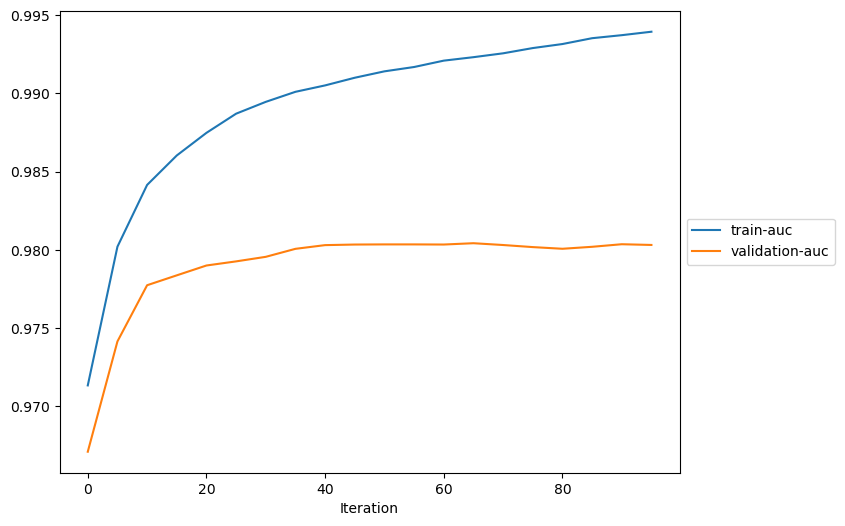

In [44]:
plot_collection(trial, "metrics")

In [45]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

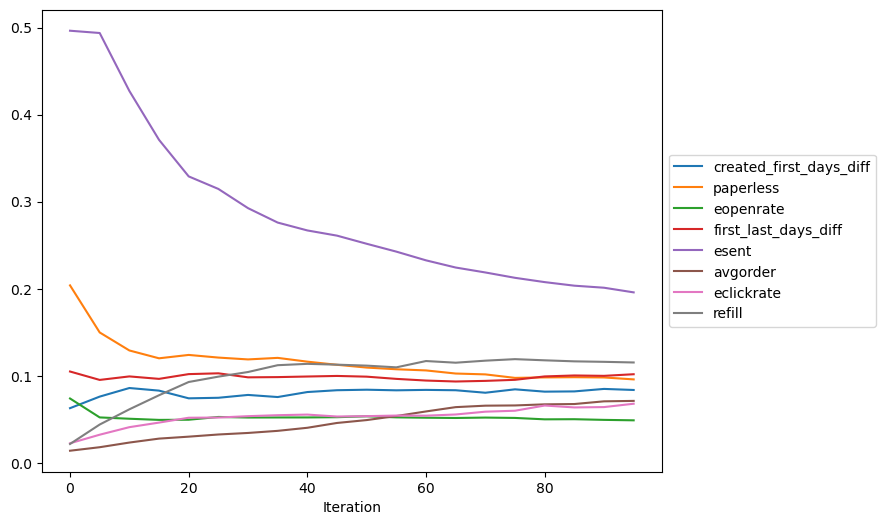

In [46]:
plot_feature_importance(trial, importance_type="cover")


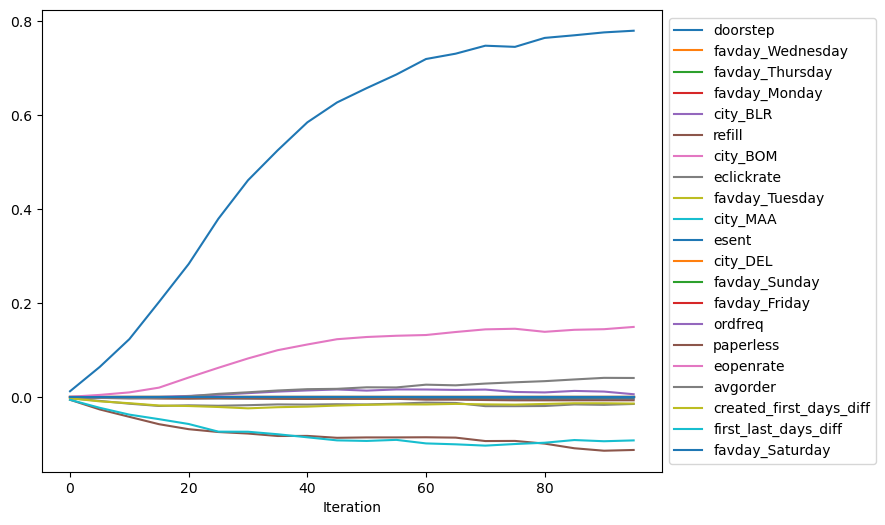

In [47]:
plot_collection(trial, "average_shap")


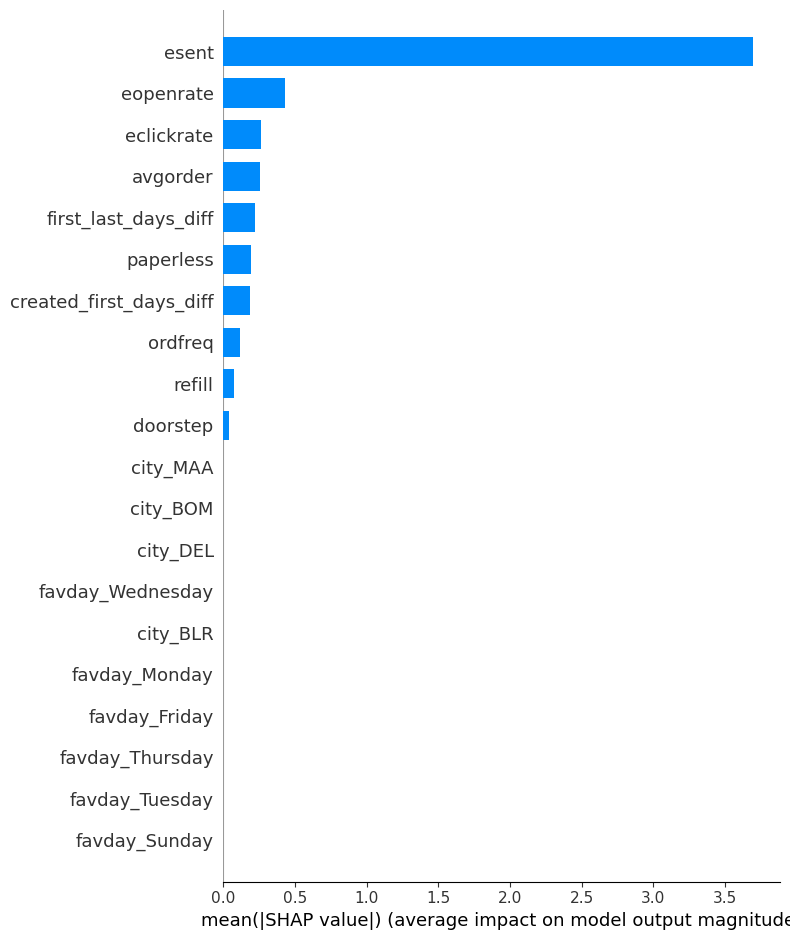

In [48]:

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [49]:
shap_base_value

2.1976511

In [50]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)


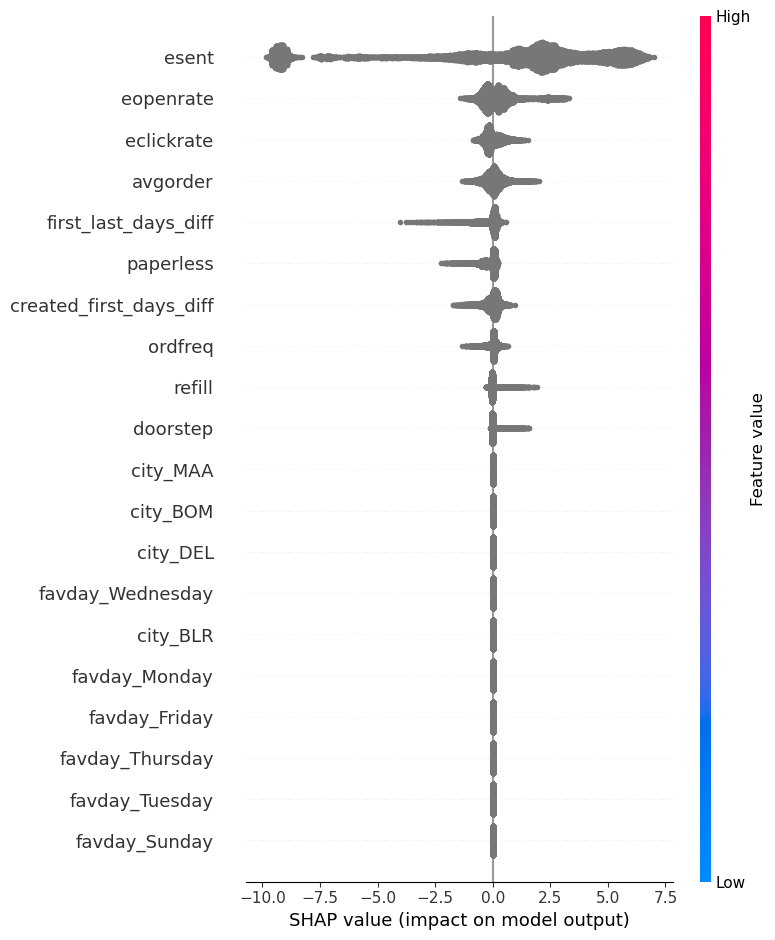

In [51]:
shap.summary_plot(shap_no_base, train_shap)


In [52]:
shap.initjs()


In [53]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [54]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [55]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)